In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
#import re
#from collections import Counter

In [2]:
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Training data 


## Train variants 

In [3]:
train_variants = pd.read_csv("/content/gdrive/MyDrive/Kaggle/msk-redefining-cancer-treatment/training_variants")
print('Number of data points : ', train_variants.shape[0])
print('Number of features : ', train_variants.shape[1])
print('Features : ', train_variants.columns.values)
train_variants.head()


Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


training_variants is a comma separated file containing the description of the genetic mutations used for training.
* ID : the id of the row used to link the mutation to the clinical evidence
* Gene : the gene where this genetic mutation is located
* Variation : the aminoacid change for this mutations
* Class : 1-9 the class this genetic mutation has been classified on

In [4]:
# Count of Unique Values of Gene
train_variants["Gene"].value_counts()

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
SHOC2       1
MDM4        1
EPCAM       1
FUBP1       1
ARID5B      1
Name: Gene, Length: 264, dtype: int64

We have 264 different genes

In [5]:
# Count of Unique Values of Variation
train_variants["Variation"].value_counts()

Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
                        ..
R1699L                   1
H123Y                    1
L755P                    1
K375A                    1
E565G                    1
Name: Variation, Length: 2996, dtype: int64

We have 2996 variation 

In [6]:
#checking number of unique values for 'Gene+Variation' combinations
G_V = train_variants.copy()
G_V['gene_and_variation']=train_variants['Gene']+' '+train_variants['Variation']
G_V.head()
G_V['gene_and_variation'].value_counts().head()

TP53 P219S     1
VHL E70K       1
FGFR2 N549T    1
NF1 R1204G     1
TP53 P47S      1
Name: gene_and_variation, dtype: int64

All combinations 'Gene + Variation' in these datasets are unique

In [7]:
train_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

This is descrete data so it is classification problem and since there are multiple descrete output possible so we can call it Multi class classification problem

In [8]:
# detect missing values 
train_variants.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

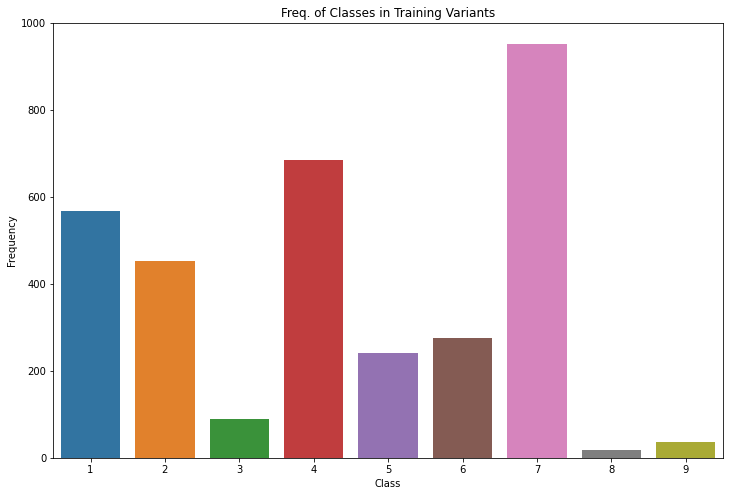

In [9]:
# plot Distribution of class
plt.figure(figsize=(12,8))
ax = sns.countplot(x="Class", data=train_variants)
plt.ylabel('Frequency'); plt.xlabel('Class')
plt.title('Freq. of Classes in Training Variants')
plt.show()

Classes seem very imbalanced

Genes that has highest number of occurrences in each class

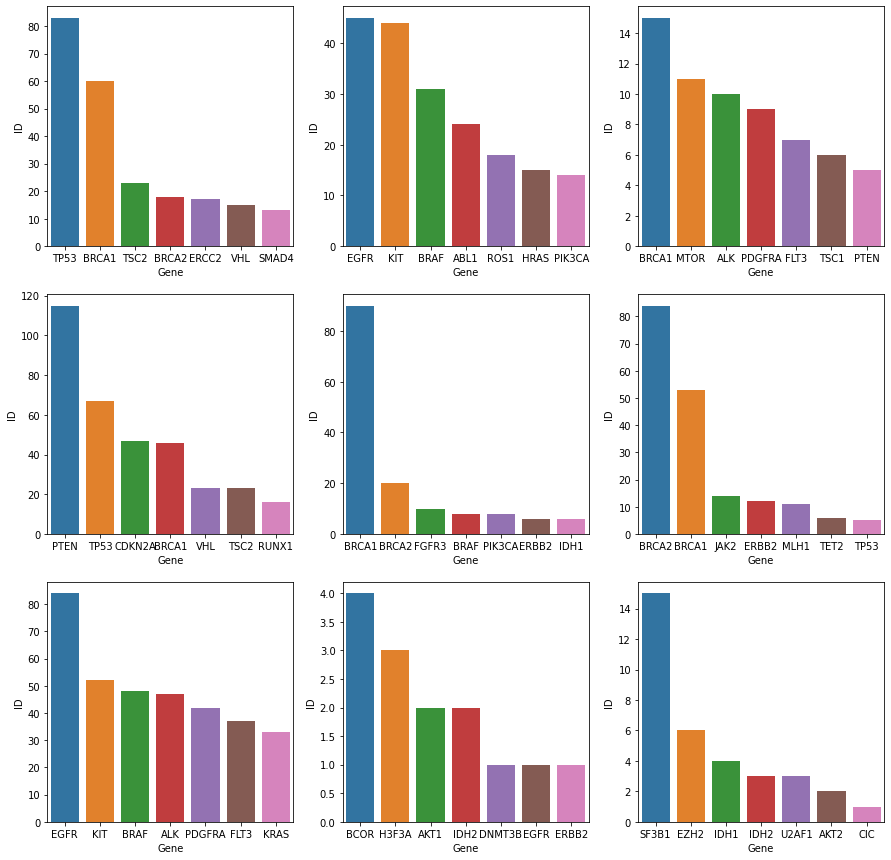

In [10]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_variants[train_variants["Class"]==((i*3+j)+1)].groupby('Gene')["ID"].count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="ID", data=sorted_gene_group_top_7, ax=axs[i][j])



Some points we can conclude from these graphs:

* BRCA1 is highly dominating Class 5
* SF3B1 is highly dominating Class 9
* BRCA1 and BRCA2 are dominating Class 6



## Train text

In [11]:
#train_text = pd.read_csv("/content/gdrive/MyDrive/Kaggle/msk-redefining-cancer-treatment/training_text",sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
# Ragou's data
train_text = pd.read_csv("/content/gdrive/MyDrive/Kaggle/msk-redefining-cancer-treatment/new_data_clean.txt",sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
print('Number of data points : ', train_text.shape[0])
print('Number of features : ', train_text.shape[1])
print('Features : ', train_text.columns.values)
train_text.head()

Number of data points :  2426
Number of features :  2
Features :  ['ID' 'Text']


,ID,Text
0,1,the c-cbl loh also positively correlated wit...
1,2,the c-cbl loh also positively correlated wit...
2,3,"most of the changes were novel, although 4 c..."
3,4,all mutations from the second group were pre...
4,5,all mutations from the second group were pre...


train_text is double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. 
* ID (the id of the row used to link the clinical evidence to the genetic mutation)
* Text (the clinical evidence used to classify the genetic mutation)

In [12]:
train_text.Text.nunique()

2104

In [13]:
#count_text = train_text.copy()
train_text.loc[:, 'Text_count']  = train_text["Text"].apply(lambda x: len( str(x).split()))
train_text.head()


,ID,Text,Text_count
0,1,the c-cbl loh also positively correlated wit...,893
1,2,the c-cbl loh also positively correlated wit...,893
2,3,"most of the changes were novel, although 4 c...",388
3,4,all mutations from the second group were pre...,123
4,5,all mutations from the second group were pre...,123


# Preprocessing 

In [14]:
# remove stopwords: the,a,an etc.
nltk.download("stopwords")
from nltk.corpus import stopwords
sw = stopwords.words("english")

def pre_processing(data):
  # lowercase text
  data = data.apply(lambda x: " ".join(i.lower() for i in  str(x).split()))
  # remove numeric values
  data = data.str.replace("\d","")
  # remove punctuations
  data = data.str.replace("[^\w\s]","")
  # remove stopwords: the,a,an etc.
  data = data.apply(lambda x: " ".join(i for i in x.split() if i not in sw))
  return data



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
train_text['Text']= pre_processing(train_text['Text'])


In [16]:
train_text.loc[:, 'Text_count']  = train_text['Text'].apply(lambda x: len( str(x).split()))
train_text.head()

,ID,Text,Text_count
0,1,ccbl loh also positively correlated egfr met m...,553
1,2,ccbl loh also positively correlated egfr met m...,553
2,3,changes novel although cases rq previously ide...,231
3,4,mutations second group predicted benign accord...,71
4,5,mutations second group predicted benign accord...,71


# Merge Datasets

In [17]:
df_merge = pd.merge(train_variants,train_text, on="ID",how="left")
df_merge.head()

,ID,Gene,Variation,Class,Text,Text_count
0,0,FAM58A,Truncating Mutations,1,NaN,NaN
1,1,CBL,W802*,2,ccbl loh also positively correlated egfr met m...,553.0
2,2,CBL,Q249E,2,ccbl loh also positively correlated egfr met m...,553.0
3,3,CBL,N454D,3,changes novel although cases rq previously ide...,231.0
4,4,CBL,L399V,4,mutations second group predicted benign accord...,71.0




There are multiple rows with similar texts let us check how many of them are unique and whether all similar texts belongs to same class

In [26]:
df_merge['Text'] = df_merge['Text'].astype(str)

In [28]:
count_grp = df_merge.groupby('Class')["Text_count"]
count_grp.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
1,384.0,548.088542,857.622092,5.0,111.0,241.0,555.00,6135.0
2,298.0,598.989933,1091.844054,19.0,106.0,243.5,650.25,11378.0
3,64.0,274.828125,331.729597,23.0,67.0,221.0,369.25,2286.0
4,560.0,509.132143,670.027314,13.0,124.0,303.0,633.25,5711.0
5,181.0,312.419890,365.076842,4.0,119.0,203.0,366.00,2482.0
6,206.0,344.271845,686.328595,1.0,36.5,106.0,314.75,6193.0
7,691.0,930.810420,1368.795450,24.0,180.0,465.0,1090.50,11513.0
8,14.0,1058.500000,1776.260755,51.0,265.0,471.0,778.25,6813.0
9,28.0,1140.035714,2050.111568,54.0,132.5,221.0,813.50,7054.0


In [18]:
df_merge[df_merge["Text_count"]==1.0]

,ID,Gene,Variation,Class,Text,Text_count
2780,2780,BRCA2,V894I,6,vi,1.0
2782,2782,BRCA2,R2502C,6,rc,1.0
2802,2802,BRCA2,N2436I,6,ni,1.0
2821,2821,BRCA2,C1365Y,6,cy,1.0
2870,2870,BRCA2,V2969M,6,vm,1.0
2879,2879,BRCA2,W2626C,6,wc,1.0
2883,2883,BRCA2,T2722R,6,tr,1.0


we can see there are some entries without any text data

In [ ]:
# Fill NaN values with Gene & Variation 
df_merge.loc[df_merge["Text_count"]==1.0,"Text"] = df_merge["Gene"] + " " + df_merge["Variation"]

Get distribution of text count for each class

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 47.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 41.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 28.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 62.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 49.2% of the points cannot be placed; y

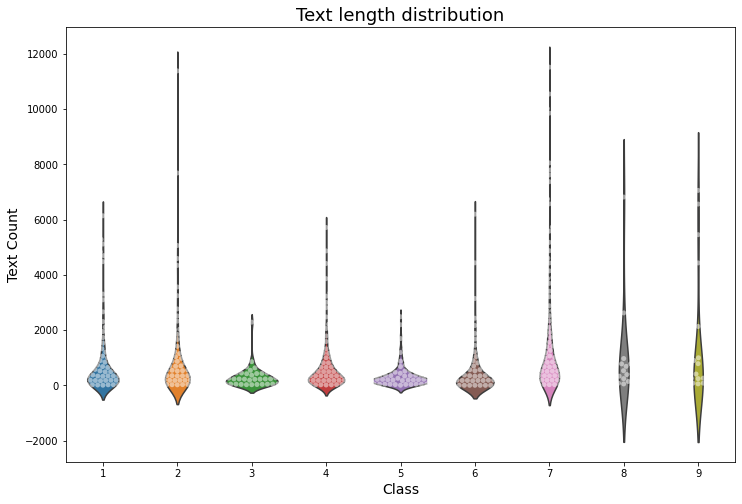

In [19]:
plt.figure(figsize=(12,8))
gene_count_grp = df_merge.groupby('Gene')["Text_count"].sum().reset_index()
sns.violinplot(x="Class", y="Text_count", data=df_merge, inner=None)
sns.swarmplot(x="Class", y="Text_count", data=df_merge, color="w", alpha=.5);
plt.ylabel('Text Count', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Text length distribution", fontsize=18)
plt.show()


 All classes have most counts in between 0 to 20000. Just as expected

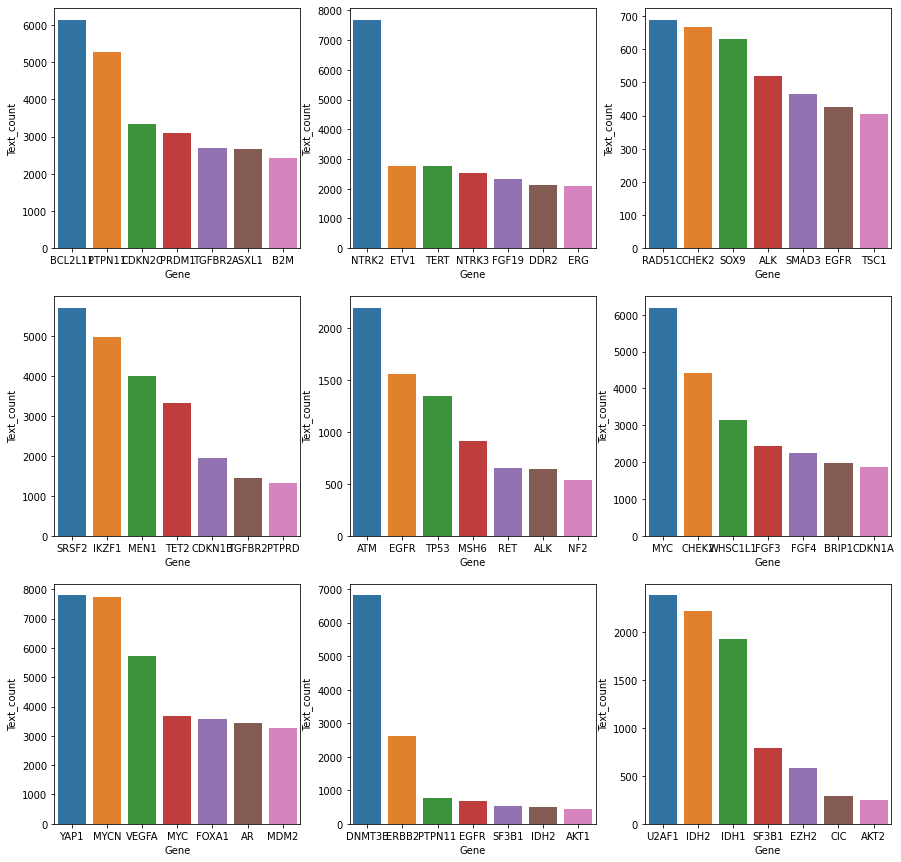

In [20]:
# how many times the gene is cited in the articles in each class
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = df_merge[df_merge["Class"]==((i*3+j)+1)].groupby('Gene')["Text_count"].mean().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('Text_count', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="Text_count", data=sorted_gene_group_top_7, ax=axs[i][j])

# LSTM

In [29]:
# Use the Keras tokenizer, vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary)
# the maximum number of words to keep, based on word frequency / load the dataset but only keep the top n words, zero the rest
num_words = 100
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_merge['Text'].values) # Updates internal vocabulary based on a list of texts.

In [ ]:
tokenizer.word_index # get the index of each word

words contain al et => no significant word 

must take the gene, mutation, variation ... 



In [34]:
# Pad the data 
X = tokenizer.texts_to_sequences(df_merge['Text'].values) # Transforms each text in texts to a sequence of integers, Only top num_words most frequent words will be taken into account.
X = pad_sequences(X, maxlen=100) # transforms a lists of integers into a 2D Numpy array of shape (num_samples, num_timesteps)


In [45]:
num_words = 100
embed_dim = 64
lstm_out = 32

model = Sequential(
    [
        Embedding(num_words, embed_dim, input_length = X.shape[1]),
        LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2),
        Dense(9, activation = "relu"),
        Dense(9,activation='softmax')
    ]
)

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 64)           6400      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 297       
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 90        
Total params: 19,203
Trainable params: 19,203
Non-trainable params: 0
_________________________________________________________________
None


### Plot the model 

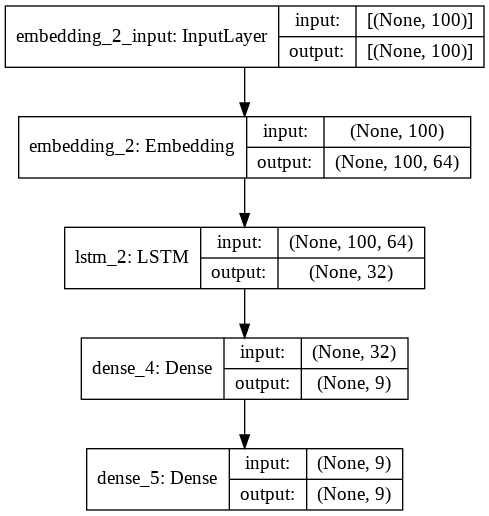

In [39]:
keras.utils.plot_model(model, "my_first_model_shapes.png", show_shapes= True)

### Split the data 

In [40]:
Y = pd.get_dummies(df_merge['Class']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2656, 100) (2656, 9)
(665, 100) (665, 9)


### Model Training 

In [46]:
batch_size = 32
# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')
history = model.fit(X_train, Y_train, epochs=20, batch_size=batch_size, validation_split=0.2, callbacks=[ckpt_callback])

Epoch 1/20
67/67 [==============================] - 10s 108ms/step - loss: 2.1118 - accuracy: 0.1634 - val_loss: 2.0418 - val_accuracy: 0.1936

Epoch 00001: val_loss improved from inf to 2.04178, saving model to keras_model
INFO:tensorflow:Assets written to: keras_model/assets
Epoch 2/20
67/67 [==============================] - 7s 104ms/step - loss: 1.9691 - accuracy: 0.2062 - val_loss: 1.9193 - val_accuracy: 0.3102

Epoch 00002: val_loss improved from 2.04178 to 1.91927, saving model to keras_model
INFO:tensorflow:Assets written to: keras_model/assets
Epoch 3/20
67/67 [==============================] - 7s 104ms/step - loss: 1.7904 - accuracy: 0.3686 - val_loss: 1.7600 - val_accuracy: 0.3703

Epoch 00003: val_loss improved from 1.91927 to 1.75997, saving model to keras_model
INFO:tensorflow:Assets written to: keras_model/assets
Epoch 4/20
67/67 [==============================] - 7s 103ms/step - loss: 1.6570 - accuracy: 0.4200 - val_loss: 1.7002 - val_accuracy: 0.3703

Epoch 00004: val_

### Testing 

In [47]:
_, acc = model.evaluate(X_test, Y_test, verbose= 1)
print('>%.3f' % (acc * 100.0))


21/21 [==============================] - 0s 13ms/step - loss: 1.5911 - accuracy: 0.4451
>44.511


### Plot Model loss and accuracy

In [48]:
# list all data history 
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<function matplotlib.pyplot.show>

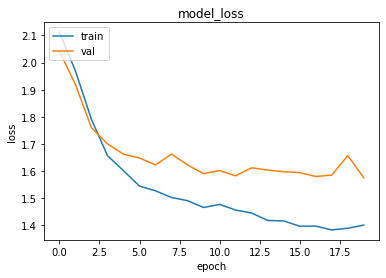

In [49]:
# visualize training and validation losses  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show 

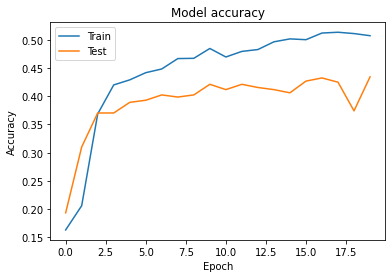

In [50]:
# visualize training and validation accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()